# Implementing Fast R-CNN, Faster R-CNN, Mask R-CNN and 100 layer tiramisu

## Imports 

In [195]:
import sys
import os
import importlib
import shutil
import numpy as np
import threading
import keras
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import selectivesearch
importlib.reload(selectivesearch)
from selectivesearch import get_selective_search_regions

import utils
importlib.reload(utils)
from utils import *

import pascal_voc_reader
importlib.reload(pascal_voc_reader)

from IPython.core.debugger import Tracer

%matplotlib inline

## Load Pascal VOC data

In [196]:
data_path = './data/'

all_samples, classes_count, class_mapping = pascal_voc_reader.get_data(
    data_path)
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    # Add the background class with index 0
    class_mapping = {k: v + 1 for k, v in class_mapping.items()}
    class_mapping['bg'] = 0

Parsing annotation files
[Errno 2] No such file or directory: './data/VOC2012/ImageSets/Main/test.txt'


In [197]:
class_mapping

{'aeroplane': 12,
 'bg': 0,
 'bicycle': 16,
 'bird': 3,
 'boat': 13,
 'bottle': 18,
 'bus': 20,
 'car': 5,
 'cat': 14,
 'chair': 7,
 'cow': 2,
 'diningtable': 6,
 'dog': 8,
 'horse': 10,
 'motorbike': 9,
 'person': 4,
 'pottedplant': 19,
 'sheep': 15,
 'sofa': 17,
 'train': 1,
 'tvmonitor': 11}

In [198]:
classes_count

{'aeroplane': 1002,
 'bg': 0,
 'bicycle': 837,
 'bird': 1271,
 'boat': 1059,
 'bottle': 1561,
 'bus': 685,
 'car': 2492,
 'cat': 1277,
 'chair': 3056,
 'cow': 771,
 'diningtable': 800,
 'dog': 1598,
 'horse': 803,
 'motorbike': 801,
 'person': 17401,
 'pottedplant': 1202,
 'sheep': 1084,
 'sofa': 841,
 'train': 704,
 'tvmonitor': 893}

In [199]:
len(all_samples)

17125

In [225]:
all_imgs

[{'bboxes': [{'class': 'train', 'x1': 86, 'x2': 421, 'y1': 113, 'y2': 227}],
  'filepath': './data/VOC2012/JPEGImages/2010_000984.jpg',
  'height': 366,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'cow', 'x1': 106, 'x2': 215, 'y1': 333, 'y2': 401}],
  'filepath': './data/VOC2012/JPEGImages/2009_003218.jpg',
  'height': 500,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'bird', 'x1': 244, 'x2': 327, 'y1': 67, 'y2': 150}],
  'filepath': './data/VOC2012/JPEGImages/2008_002624.jpg',
  'height': 375,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'person', 'x1': 75, 'x2': 396, 'y1': 95, 'y2': 375}],
  'filepath': './data/VOC2012/JPEGImages/2008_000316.jpg',
  'height': 375,
  'imageset': 'trainval',
  'width': 500},
 {'bboxes': [{'class': 'car', 'x1': 143, 'x2': 189, 'y1': 103, 'y2': 118},
   {'class': 'car', 'x1': 196, 'x2': 244, 'y1': 102, 'y2': 116},
   {'class': 'car', 'x1': 260, 'x2': 306, 'y1': 102, 'y2': 117},
   {'class': 

In [248]:
filenames = [sample['filepath'] for sample in all_samples]
# print(filenames)

In [ ]:
truth_boxes = [sample['filepath'] for sample in all_samples]

In [ ]:
torchvision.utils.da

# Fishing

## Load Data

In [2]:
image_size = (360, 640)

In [3]:
# Load data
data_gen = get_batch('../fishing/data/train', image_size)
filenames = data_gen.filenames

Found 3212 images belonging to 8 classes.


In [32]:
all_samples = get_all_generator_samples(data_gen)
samples_filename = 'test_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
save_array(samples_filename, all_samples)

In [4]:
samples_filename = 'train_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

(3212, 360, 640, 3)

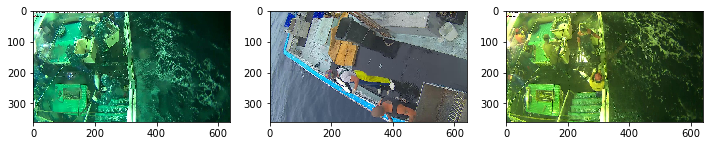

In [5]:
plot_images(all_samples[:3])

## Fast R-CNN

### Selective Search

In [196]:
def get_ss_regions(i):
    return (filenames[i], get_selective_search_regions(all_samples[i].astype('uint8'),
                                                       scale=50))

1026


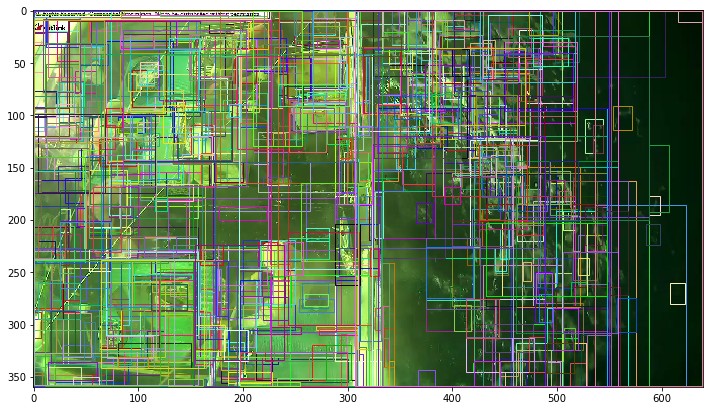

CPU times: user 16.6 s, sys: 56 ms, total: 16.6 s
Wall time: 16.4 s


In [195]:
% % time
img = all_samples[100].astype('uint8')
regions = get_selective_search_regions(img, scale=50)
print(len(regions))
display_image_regions(img, regions, figsize=(12, 12))

In [118]:
% % time
regions = []
for i in range(50):
    regions.append(get_selective_search_regions(all_samples[i].astype('uint8'),
                                                scale=250))

CPU times: user 2min 42s, sys: 520 ms, total: 2min 43s
Wall time: 2min 43s


It is quite slow so let's see if we can speed it up with multithreading.

#### SS with multithreading


Test a few different number of workers to figure out what works best.

In [ ]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

2m 1s

In [120]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=8) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

CPU times: user 3min 53s, sys: 7.54 s, total: 4min 1s
Wall time: 2min 7s


In [121]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=16) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

CPU times: user 4min 1s, sys: 9.51 s, total: 4min 11s
Wall time: 2min 11s


In [122]:
% % time
num_samples = 50  # len(all_samples)
regions = []
with ThreadPoolExecutor(max_workers=32) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

CPU times: user 4min 10s, sys: 10.4 s, total: 4min 21s
Wall time: 2min 15s


#### SS with multiprocessing

In [128]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=2) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 23.8s

In [123]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 10.7s

In [124]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=8) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

 1m 11.8s

In [125]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=16) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 14.9s

In [126]:
num_samples = 50  # len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=32) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

1m 18.2s

So it seems miltiprocessing with 4 processes works best: the P2 istance this is running on has 4 virtual CPUs, apparently with a single thread on each.

#### Compute regions for all images

##### Validation set regions

In [10]:
# Load data
data_gen = get_batch('../fishing/data/valid', image_size)
filenames = data_gen.filenames

samples_filename = 'valid_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

Found 547 images belonging to 8 classes.


(547, 360, 640, 3)

In [25]:
num_samples = len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

save_array('valid_regions.bcolz', list(regions))

##### Train set regions

In [197]:
# Load data
data_gen = get_batch('../fishing/data/train', image_size)
filenames = data_gen.filenames

samples_filename = 'train_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

Found 3212 images belonging to 8 classes.


(3212, 360, 640, 3)

In [198]:
num_samples = len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

save_array('train_regions_scale_50.bcolz', list(regions))

##### Test set regions

In [35]:
# Load data
data_gen = get_batch('../fishing/data/test', image_size)
filenames = data_gen.filenames

samples_filename = 'test_samples_{}x{}.bcolz'.format(
    image_size[0], image_size[1])
all_samples = load_array(samples_filename)
all_samples.shape

Found 1000 images belonging to 1 classes.


(1000, 360, 640, 3)

In [36]:
num_samples = len(all_samples)
regions = []
with ProcessPoolExecutor(max_workers=4) as executor:
    regions = executor.map(get_ss_regions, range(num_samples))

save_array('test_regions.bcolz', list(regions))

##### Load regions

In [207]:
def load_regions(filename):
    regions = load_array(filename)
    # remove the filename from the array
    return [list(region[1]) for region in regions]


train_regions = load_regions('train_regions_scale_50.bcolz')
len(train_regions)

3212

#### Load groundtruth boxes

In [93]:
save_dir = '../fishing/intermediate/bboxes/'
train_truth = load_array(os.path.join(
    save_dir, 'train_bbox_prepared_{}x{}'.format(image_size[0], image_size[1])))
valid_truth = load_array(os.path.join(
    save_dir, 'valid_bbox_prepared_{}x{}'.format(image_size[0], image_size[1])))
train_truth.shape, valid_truth.shape

((3212, 4), (547, 4))

In [94]:
# the truth bboxes are in format (x,y,h,w) and we want them in (x,y,w,h)
train_truth[:, [2, 3]] = train_truth[:, [3, 2]]
valid_truth[:, [2, 3]] = valid_truth[:, [3, 2]]

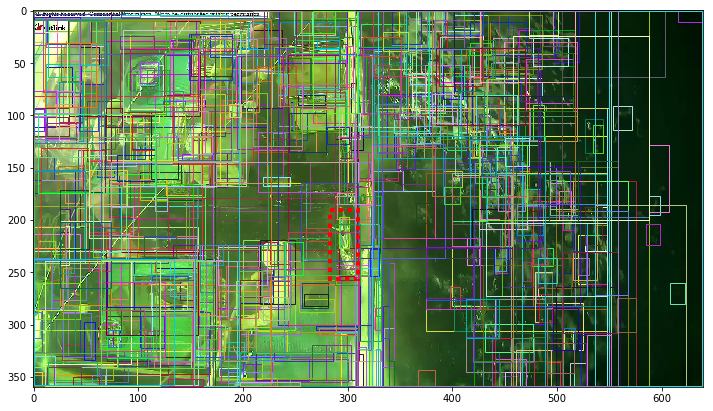

array([ 283.5,  190.5,   65.5,   26. ])

In [208]:
img_index = 100
img = all_samples[img_index].astype('uint8')
regions = train_regions[img_index]
truth_box = train_truth[img_index]

display_image_regions(
    img, regions, ground_truth_box=truth_box, figsize=(12, 12))
train_bboxes[100]

#### Do proposed regions have intersections with the groundtruths

Let's calculate how many of our ROIs have IOUs >= 0.5 and in [0.1, 0.5)


In [209]:
# Intersection over Union metric
def iou(box1, box2):
    ''' Computes the intersection over union for two boxes.
    '''
    epsilon = 1e-7
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x1 = max(x1, x2)
    intersection_y1 = max(y1, y2)
    intersection_x2 = min(x1 + w1, x2 + w2)
    intersection_y2 = min(y1 + h1, y2 + h2)

    # The area can't be less than 0
    intersection_area = (max(0, intersection_x2 - intersection_x1)
                         * max(0, intersection_y2 - intersection_y1))

    true_area = abs(h1 * w1)
    pred_area = abs(h2 * w2)
    iou = intersection_area / (true_area + pred_area
                               - intersection_area + epsilon)

    return iou


# Some tests
iou_computed = iou(
    [0, 1, 12, 10],
    [12, 11, 6, 6])
np.testing.assert_array_almost_equal(iou_computed, 0)

iou_computed = iou(
    [0, 1, 10, 9],
    [9, 9, 5, 5])
np.testing.assert_array_almost_equal(iou_computed, 1 / 114)

iou_computed = iou(
    [10, 11, 6, 5],
    [12, 13, 1, 2])
np.testing.assert_array_almost_equal(iou_computed, 2 / 30)

iou_computed = iou(
    [283.5, 190.5, 26., 65.5],
    [479, 244, 22, 35])
np.testing.assert_array_almost_equal(iou_computed, 0)

iou_computed = iou(
    [283.5, 190.5, 26., 65.5],
    [437, 133, 29, 33])
np.testing.assert_array_almost_equal(iou_computed, 0)

In [210]:
max_ious = []
for truth, regions in zip(train_truth, train_regions):
    positive_samples = []
    negative_samples = []
    max_iou = 0
    min_iou = 0
    for region in regions:
        iou_computed = iou(truth_box, region)
        if iou_computed >= 0.3:
            positive_samples.append(region)
        elif iou_computed >= 0.05 and iou_computed < 0.3:
            negative_samples.append(region)
        max_iou = max(iou_computed, max_iou)
    max_ious.append(max_iou)
#     print(len(positive_samples), len(negative_samples))

In [215]:
np.sum(np.array(max_ious) >= 0.5)

384

In [ ]:
display_image_regions(img, positive_samples,
                      ground_truth_box=truth_box, figsize=(12, 12))

## ROI Pooling

In [194]:
import torch, torchvision
from torch.autograd import Variable

In [186]:
test_input = Variable(torch.range(0, 1759).view(1, 2, 22, 40)).cuda()
test_rois = Variable(torch.FloatTensor([[0, 90., 110., 10., 60.]]))

In [188]:
class ROIPooling(torch.nn.Module):
    def __init__(self, size=(7, 7), spatial_scale=(1. / 16.)):
        ''' 
        size: The output size for each region of interest.
        spatial_scale: How much to scale ROI dimensions before slicing
            activations map.
        '''
        super(ROIPooling, self).__init__()
        assert (len(size) == 2), 'ROI Pooling expects a 2d output size.'
        self.size = size
        self.spatial_scale = spatial_scale

    def forward(self, x, all_rois):
        ''' Do ROI pooling over the convolutional activations maps. 
        Each ROI specifies a region of convolutional features to resize to a 
        predefined size (usually 7x7) using Max Pool.

        Args:
            x: feature activations map: sample_index x channels x width x height
            all_rois: Region tensor. Each region is (sample_index, x, y, w, h)
        '''
        assert (len(x.size()) == 4), ('ROI Pooling expects feature maps as '
                                      + '4d Tensor.')
        assert (all_rois.size(1) == 5), (
            'ROI Pooling expects each ROIs to be like: (sample, x, y, h, w).')

        # The output will be sized:
        # (number of rois, conv channels, roi output as a vector)
        output_size = (all_rois.size()[0], x.size(
            1), self.size[0] * self.size[1])
        outputs = Variable(torch.zeros(output_size).cuda())
        for roi_index, roi in enumerate(all_rois):
            img_index = int(roi.data[0])
            roi_scaled = roi.data.float() * self.spatial_scale
            _, x1, y1, w, h = roi_scaled
            x2, y2 = x1 + w, y1 + h
            # Make sure minimal slice size is 1 across x and y
            x2 = max(x2, x1 + 1)
            y2 = max(y2, y1 + 1)
            x1, y1, x2, y2 = round(x1), round(y1), round(x2), round(y2)

            roi_activations = x[img_index, :, x1:x2, y1:y2]
            output = torch.nn.modules.pooling.AdaptiveMaxPool2d(self.size)(
                roi_activations)
            outputs[roi_index] = output.view(-1, self.size[0] * self.size[1])

        return outputs

In [189]:
output = ROIPooling((7, 7)).forward(test_input, test_rois)

# 2x1x4 tensor
test_output = np.asarray(
    [[[247., 248., 248., 249., 249.0, 250., 250.] * 7,
      [1127., 1128., 1128., 1129., 1129., 1130., 1130.] * 7]],
    dtype=float)

assert np.isclose(
    output.data.cpu().numpy(), test_output).all()

In [ ]:
torchvision.models.vgg16_bn